<a href="https://colab.research.google.com/github/SaraAlinejad/vae_test_1/blob/main/Assignment-2/Assignment-2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Chemical Applications of Machine Learning (CHEM 4930/5610) - Spring 2026

### Assignment 2 - Deadline 2/3/2026
Points 10

#### General Comments
All figures and graph should have approriate labels on the two axis, and should include a legend with appropriate labels of the different plots.

The notebook should be return in working format. That is, I should be able to reset all the output and re-run all the cells and get the same results as you obtained.

**You should start by saving a copy of the notebook to your Google Drive so you preserve all changes.**

**Please add your name as a suffix to the filname**

**Student Name**: Add your name here

**AI usage statement:**
Here you should give a statement about any usage of AI tools to assist you with the coding.

### Task 1 - 10 points

In this task, we will consider the Bradley Melting Point Dataset, which is curated chemical dataset with melting points of around 3,000 chemical compounds, see [here](https://www.kaggle.com/datasets/aliffaagnur/melting-point-chemical-dataset/data).

This dataset is stored in a comma-separated values (csv) file, which is common format used to start data in text files. We can load this into a pandas DataFrame using the `load_csv` function.

In this dataset, we have the compounds names, SMILES strings, and the melting point in Celsius.

#### A)
Identify in the dataset the chemical compounds with the 5 lowest melting points and 5 highest melting points and visualize their 2D chemical structure using RDKit and the [mols2grid package](https://mols2grid.readthedocs.io/en/latest/), where you display the melting point values on the grid, see [here](https://colab.research.google.com/github/PatWalters/practical_cheminformatics_tutorials/blob/main/fundamentals/A_Whirlwind_Introduction_To_The_RDKit.ipynb#scrollTo=N3CR7rMF3sg7) for an example of the usage of mols2grid.

#### B)
Calculate the following properties for the molecules using RDKIt:
- The molecular weight
- The number of heavy atoms
- Number of hydrogen bond acceptors
- Number of hydrogen bond donors
- [Octanol-water partition coefficient - LogP](https://pubs-acs-org.libproxy.library.unt.edu/doi/10.1021/ci990307l)
- [Topological polar surface area (TPSA) descriptor](https://pubs-acs-org.libproxy.library.unt.edu/doi/abs/10.1021/jm000942e)
- Topological polar surface area (TPSA) descriptor, including S and P atoms, see [here](https://www.rdkit.org/docs/RDKit_Book.html#implementation-of-the-tpsa-descriptor)

Note: for some of the molecules, the TPSA descriptor will give a value of zero. When doing any analysis for the TPSA descriptor, you should ignore these values.

#### C)
Write out to a new csv file values of all the properties calculated in B) along with the compound names, SMILES strings, and the melting point in Celsius. Here, when writing this file, you should ignore any compounds where the SMILES conversion did not work correctly.

#### D)
Perform a linear regression analysis using scikit-learn where you look at the correlation of each of the properties calculated in B) with melting temperature. Here, each property should be considered individually.

To avoid outliers, filter out (i.e., remove) the compounds with the lowest 10% and the highest 10% melting temperature. Make a histogram that shows this filtering. Furthermore, for each property, filter out the compounds with lowest 10% and highest 10% values (again making a histogram that shows this filtering). Only consider the joint remaining compounds in your linear regression analysis for each property.

When performing the linear regression, employ a 70%/30% training/test split.

Calculate the coefficient of determination, $R^2$, for both the training dataset and the test dataset and report both.

You should make figure that shows the data along with the linear curve coming from the linear regression. In the figure, it should be clear which data points are in the training and test set (e.g., by having them in different colors). Include the $R^2$ values on the figure.

From your analysis, which of the properties correlates best with the melting temperature?

#### E)
For two of the properties from D) (e.g., the ones that correlate best with the melting point), perform [RANSAC](https://en.wikipedia.org/wiki/Random_sample_consensus) regression, which is method that takes outliers into account when performing linear regression and does not include them in the final modeling, see [here](https://scikit-learn.org/stable/auto_examples/linear_model/plot_ransac.html).

In the figure, it should be clear which data points are in inlier set and which are in the outlier set (e.g., by showing them in different colors).


AI usage statement: in some cases I used AI to solve errors, improving the comments both in term of dictation and also clearity. also for some questions, I was curiouse how chatgpt whould write a code and I have added them here as "second approch;commented"

In [1]:
# Bash script to download all the dataset. Don't worry if you don't understand it
%%bash

url="https://raw.githubusercontent.com/valsson-group/UNT-ChemicalApplicationsOfMachineLearning-Spring2026/refs/heads/main/Assignment-2/"
dataset_filename="BradleyDoublePlusGoodMeltingPointDataset.csv"

rm -f ${dataset_filename}

wget ${url}/${dataset_filename} &> /dev/null

ls

BradleyDoublePlusGoodMeltingPointDataset.csv
sample_data


In [33]:
!pip -q install rdkit mols2grid
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, RANSACRegressor
from sklearn.metrics import r2_score
import mols2grid
from rdkit import Chem
from rdkit.Chem import Descriptors, Lipinski, Crippen, rdMolDescriptors
from sklearn.mixture import GaussianMixture
from matplotlib.patches import Ellipse
from sklearn.neighbors import KernelDensity


In [40]:
CSV_PATH = "BradleyDoublePlusGoodMeltingPointDataset.csv"

df = pd.read_csv(CSV_PATH)

print("Shape:", df.shape)
print("Columns:", list(df.columns))
df.head()

Shape: (3041, 11)
Columns: ['key', 'name', 'smiles', 'mpC', 'csid', 'link', 'source', 'count', 'min', 'max', 'range']


,key,name,smiles,mpC,csid,link,source,count,min,max,range
0,27956,cyclobutylmethane,C1(CCC1)C,-161.51,11232,http://pubs.acs.org/doi/abs/10.1021/ja01142a048,Lemaire HP; Livingston RL Journal of the Ameri...,2,-161.51,-161.5,0.01
1,16005,Nitrogen oxide,[O-][N+]#N,-90.80,923,http://msds.chem.ox.ac.uk/,academic website,2,-90.81,-90.8,0.01
2,16127,Sulfuryl difluoride,FS(F)(=O)=O,-135.80,16647,http://msds.chem.ox.ac.uk/,academic website,2,-135.82,-135.8,0.02
3,17138,disopyramide,CC(C)N(CCC(c1ccccn1)(c2ccccc2)C(N)=O)C(C)C,94.80,3002,http://dx.doi.org/10.1021/ci700307p,Hughes LD; Palmer DS; Nigsch F and Mitchell JB...,2,94.75,94.8,0.05
4,15628,Bromine,BrBr,-7.20,22817,http://msds.chem.ox.ac.uk/,academic website,2,-7.25,-7.2,0.05


In [13]:
# ---------------------------------------------------------
#  Data Cleaning and Selection (First aproach; Faster) & Visualization)
# ---------------------------------------------------------
subset = pd.concat([df.nsmallest(5, 'mpC'), df.nlargest(5, 'mpC')])

# Visualize
mols2grid.display(subset,
                  smiles_col="smiles",
                  subset=["name", "mpC", "img"],
                  transform={"mpC": lambda x: f"{x:.1f} °C"})



In [ ]:
# ---------------------------------------------------------
#  Data Cleaning and Selection (Second aproach)
# ---------------------------------------------------------

# Ensuring the melting point column 'mpC' is numeric.
# Errors='coerce' turns non-numeric values (like text) into NaN, which we then drop.
# df['mpC'] = pd.to_numeric(df['mpC'], errors='coerce')
# df_clean = df.dropna(subset=['mpC', 'smiles'])

# # Sort the dataset by melting point
# df_sorted = df_clean.sort_values(by='mpC')

# # Select the 5 lowest and 5 highest melting points
# lowest_5 = df_sorted.head(5)
# highest_5 = df_sorted.tail(5)

# # Combine them into one DataFrame for visualization
# results_df = pd.concat([lowest_5, highest_5])

# # Let's add a clean label for the grid so we can tell which is which
# # We create a new column 'Category'
# results_df['Category'] = ['Lowest MP'] * 5 + ['Highest MP'] * 5

# print("\nSelected compounds for visualization:")
# print(results_df[['name', 'mpC', 'Category']])


# We use the display function to create an interactive grid.
# subset: controls what text fields appear on the card (we want name and melting point).
# tooltip: controls what appears when you hover over the image.
# transform: formats the numbers nicely so we don't get 10 decimal places.

# grid = mols2grid.display(
#     results_df,
#     smiles_col="smiles",   # Tell it where the SMILES strings are
#     subset=["img", "name", "mpC", "Category"], # What to show on the card
#     tooltip=["name", "mpC", "smiles"],         # What to show on hover
#     transform={"mpC": lambda x: f"{x:.2f} °C"}, # Format MP nicely
#     n_cols=5, # 5 columns to neatly show lowest on row 1 and highest on row 2 (roughly)
#     size=(150, 150) # Image size
# )

# grid

In [46]:
df["mol"] = df["smiles"].apply(Chem.MolFromSmiles)
df = df.dropna(subset=["mol"]).copy()

# ---------------------------------------------------------
# Calculate molecular properties
# ---------------------------------------------------------
df["MolWt"]          = df["mol"].apply(Descriptors.MolWt)
df["HeavyAtomCount"] = df["mol"].apply(Lipinski.HeavyAtomCount)
df["HBA"]            = df["mol"].apply(Lipinski.NumHAcceptors)
df["HBD"]            = df["mol"].apply(Lipinski.NumHDonors)
df["LogP"]           = df["mol"].apply(Crippen.MolLogP)

# TPSA
df["TPSA"]     = df["mol"].apply(lambda m: rdMolDescriptors.CalcTPSA(m))
df["TPSA_S_P"] = df["mol"].apply(lambda m: rdMolDescriptors.CalcTPSA(m, includeSandP=True))

df[["name", "mpC", "MolWt", "HeavyAtomCount", "HBA", "HBD", "LogP", "TPSA", "TPSA_S_P"]].head()

,name,mpC,MolWt,HeavyAtomCount,HBA,HBD,LogP,TPSA,TPSA_S_P
0,cyclobutylmethane,-161.51,70.135,5,0,0,1.80640,0.00,0.00
1,Nitrogen oxide,-90.80,44.013,3,2,0,0.33728,51.21,51.21
2,Sulfuryl difluoride,-135.80,102.061,5,2,0,0.17020,34.14,42.52
3,disopyramide,94.80,339.483,25,3,1,3.36190,59.22,59.22
4,Bromine,-7.20,159.808,2,0,0,1.69120,0.00,0.00


In [48]:
output_filename = "bradley_melting_point_properties.csv"

columns_to_save = [
    "name", "smiles", "mpC",
    "MolWt", "HeavyAtomCount", "HBA", "HBD",
    "LogP", "TPSA", "TPSA_S_P"
]

df[columns_to_save].to_csv(output_filename, index=False)

print(f"Saved {len(df)} compounds to '{output_filename}'.")

Saved 3025 compounds to 'bradley_melting_point_properties.csv'.


In [49]:
df_verify = pd.read_csv("bradley_melting_point_properties.csv")
print(df_verify.columns)


Index(['name', 'smiles', 'mpC', 'MolWt', 'HeavyAtomCount', 'HBA', 'HBD',
       'LogP', 'TPSA', 'TPSA_S_P'],
      dtype='object')


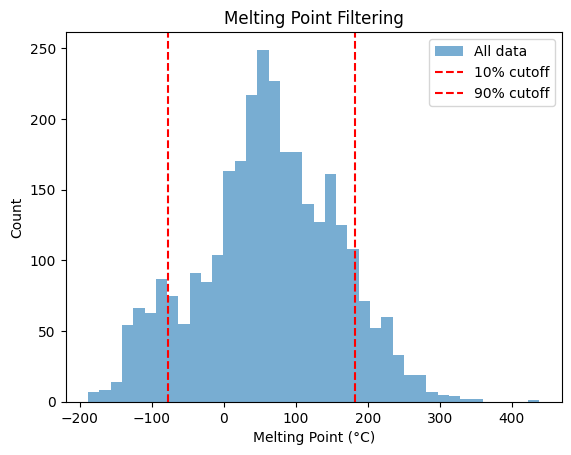

In [50]:
mp_low, mp_high = df_verify["mpC"].quantile([0.1, 0.9])

plt.hist(df_verify["mpC"], bins=40, alpha=0.6, label="All data")
plt.axvline(mp_low, color="red", linestyle="--", label="10% cutoff")
plt.axvline(mp_high, color="red", linestyle="--", label="90% cutoff")
plt.xlabel("Melting Point (°C)")
plt.ylabel("Count")
plt.legend()
plt.title("Melting Point Filtering")
plt.show()

df_mp = df_verify[(df_verify["mpC"] >= mp_low) & (df_verify["mpC"] <= mp_high)].copy()


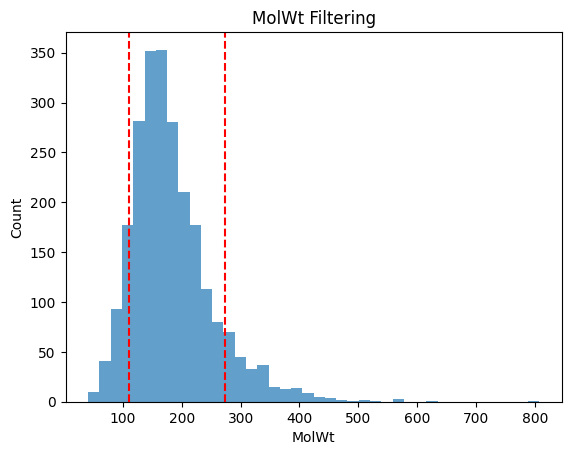

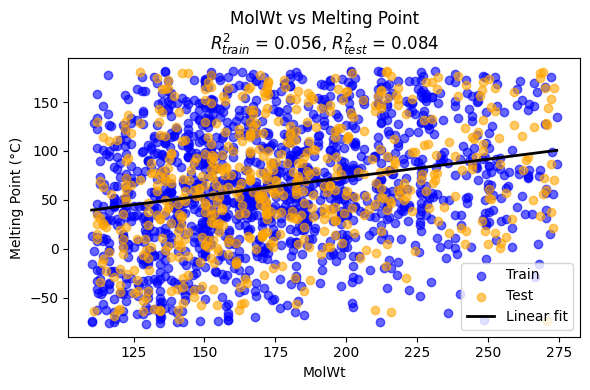

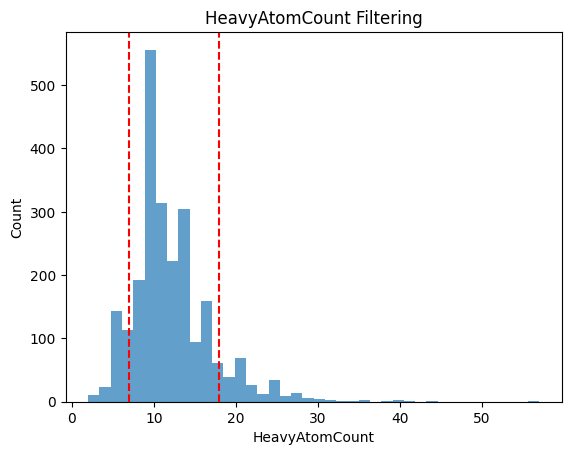

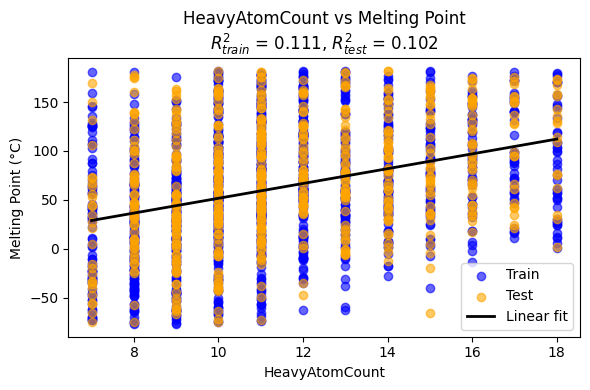

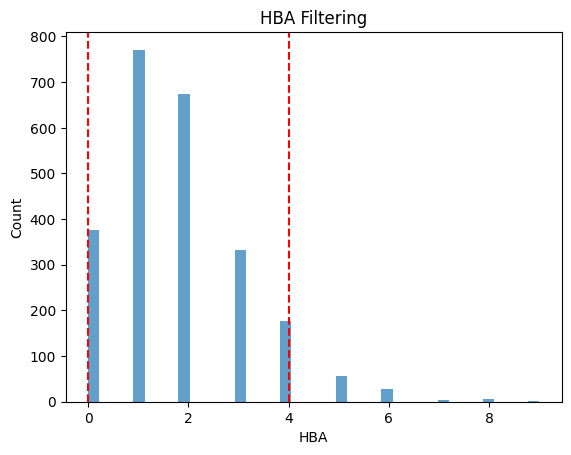

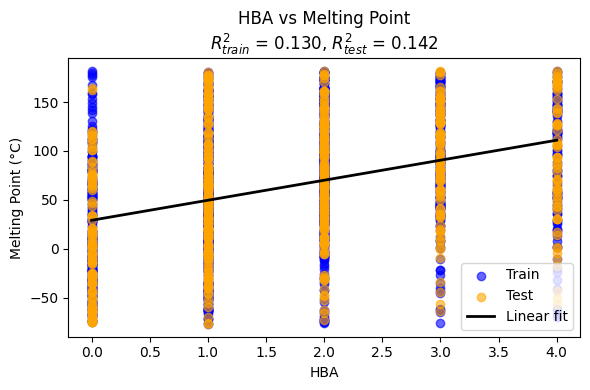

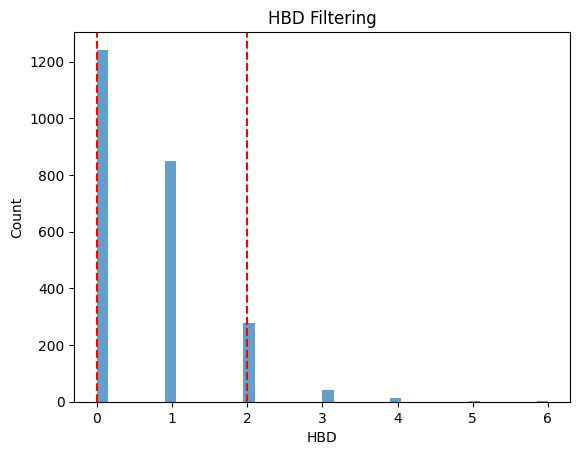

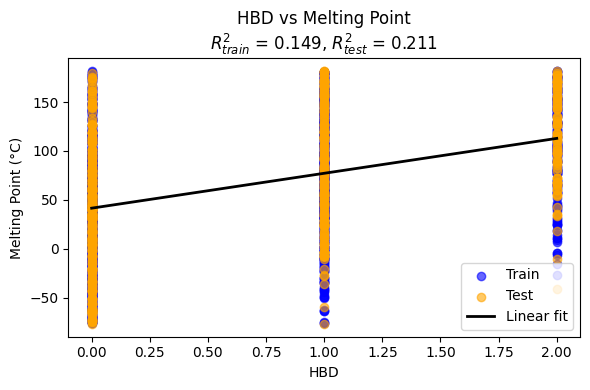

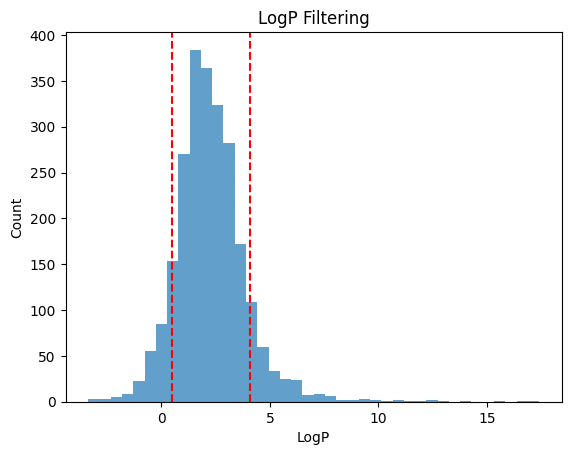

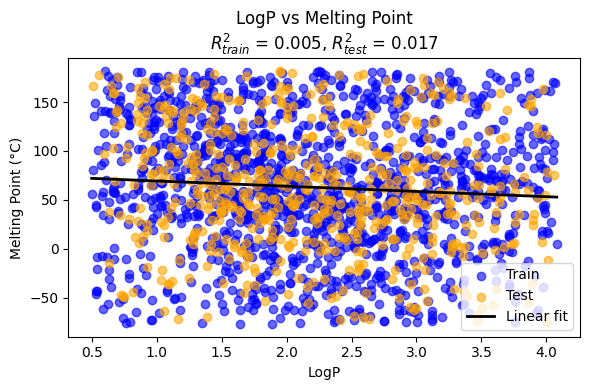

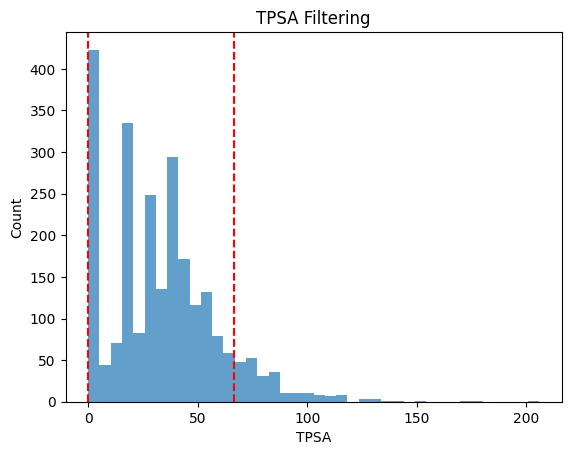

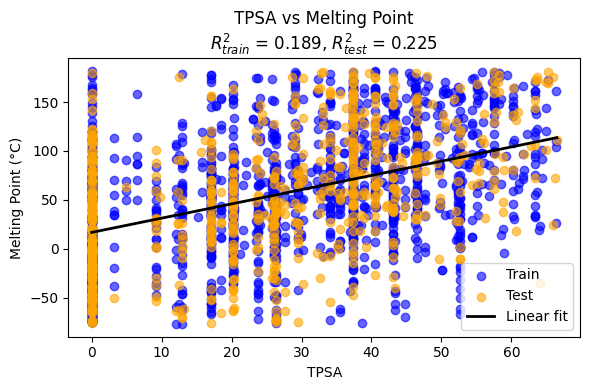

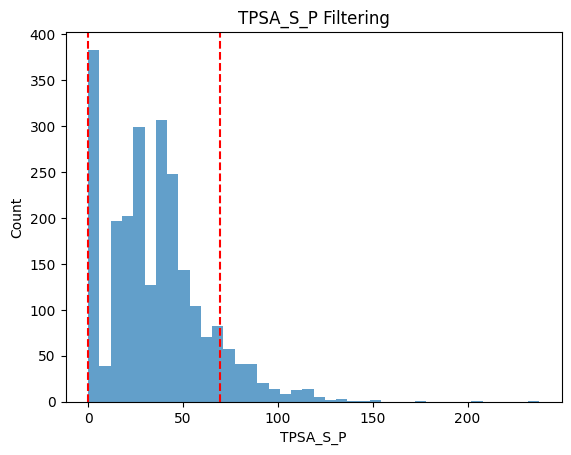

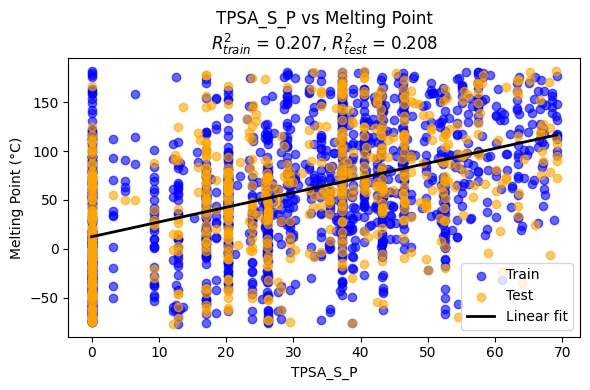

In [51]:
# we had it in task B
properties = [
    "MolWt",
    "HeavyAtomCount",
    "HBA",
    "HBD",
    "LogP",
    "TPSA",
    "TPSA_S_P"
]

results = []

for prop in properties:

    # ---------------------------------------------------------
    # Filter property outliers (10%–90%)
    # ---------------------------------------------------------
    low, high = df_mp[prop].quantile([0.1, 0.9])

    plt.hist(df_mp[prop], bins=40, alpha=0.7)
    plt.axvline(low, color="red", linestyle="--")
    plt.axvline(high, color="red", linestyle="--")
    plt.xlabel(prop)
    plt.ylabel("Count")
    plt.title(f"{prop} Filtering")
    plt.show()

    df_filt = df_mp[(df_mp[prop] >= low) & (df_mp[prop] <= high)].copy()

    # ---------------------------------------------------------
    # Prepare data
    # ---------------------------------------------------------
    X = df_filt[[prop]].values
    y = df_filt["mpC"].values

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=42
    )

    # ---------------------------------------------------------
    # Linear regression
    # ---------------------------------------------------------
    model = LinearRegression()
    model.fit(X_train, y_train)

    y_train_pred = model.predict(X_train)
    y_test_pred  = model.predict(X_test)
    r2_train = r2_score(y_train, y_train_pred)
    r2_test  = r2_score(y_test, y_test_pred)
    results.append((prop, r2_train, r2_test))

    # ---------------------------------------------------------
    # Plot data + regression line
    # ---------------------------------------------------------
    x_line = np.linspace(X.min(), X.max(), 200).reshape(-1, 1)
    y_line = model.predict(x_line)

    plt.figure(figsize=(6, 4))
    plt.scatter(X_train, y_train, color="blue", alpha=0.6, label="Train")
    plt.scatter(X_test, y_test, color="orange", alpha=0.6, label="Test")
    plt.plot(x_line, y_line, color="black", linewidth=2, label="Linear fit")
    plt.xlabel(prop)
    plt.ylabel("Melting Point (°C)")
    plt.title(
        f"{prop} vs Melting Point\n"
        f"$R^2_{{train}}$ = {r2_train:.3f}, "
        f"$R^2_{{test}}$ = {r2_test:.3f}"
    )
    plt.legend()
    plt.tight_layout()
    plt.show()


In [52]:
results_df = pd.DataFrame(
    results, columns=["Property", "R2_train", "R2_test"]
)

results_df.sort_values("R2_test", ascending=False)


,Property,R2_train,R2_test
5,TPSA,0.189389,0.224636
3,HBD,0.148759,0.210648
6,TPSA_S_P,0.207139,0.208057
2,HBA,0.129749,0.141601
1,HeavyAtomCount,0.111133,0.101780
0,MolWt,0.055804,0.083986
4,LogP,0.005342,0.017308


In [54]:
mp_low, mp_high = df["mpC"].quantile([0.1, 0.9])
df_mp = df[(df["mpC"] >= mp_low) & (df["mpC"] <= mp_high)].copy()

# ---------------------------------------------------------
# Choose two best-correlated properties
# ---------------------------------------------------------
top_props = ["TPSA", "HBD"]

print("Using properties:", top_props)

Using properties: ['TPSA', 'HBD']


### Task 2 - Optional 5 points

Here we will consider a dataset of two variables $x$ and $y$ sampled from a two-dimensional probability density $P(x,y)$ that is unknown.

The dataset is given as a time series in the file `Dataset_RotatedWQ-Potential.data`.

The main task is to perform a Gaussian Mixture Model analysis on this two-dimensional dataset.

#### A)
Plot the dataset, both the time series and also a scatter plot for the $x$ and $y$ variables.

Looking at the scatter plot, how many Gaussian components do you think are needed in the Gaussian Mixture Model analysis?

#### B)
Using Seaborn (or scikit-learn) estimate the two-dimensional probability density $P(x,y)$ using kernel density estimation.

#### C)
Perform a Gaussian Mixture Model analysis for a different number of components, and obtain the Bayesian information criterion (bic) and Akaike information criterion (aic) values and based on them identify the optimal number of components (remember that for both a lower value is better).

#### D)
For the optimal number of components, perform a final Gaussian Mixture Model analysis that you will analyze.

- What is the weight of each Gaussian components.

- What is the percentage of samples that are hard classifed to each cluster.

- Make a scatter plot that shows how the samples are hard classifed to each cluster. In this plot, indicate the center of each Gaussian components.

- Make figures that shows how the samples are soft classifed to each cluster (e.g., the probablity that they belong to a given cluster). In each plot, indicate the center of corresponding Gaussian components.

- Plot a two-dimensional surface of the $P(x,y)$ estimated by the Gaussian Mixture Model. How does this compare to the KDE plot from B)?


In [55]:
# Bash script to download all the dataset. Don't worry if you don't understand it
%%bash

url="https://raw.githubusercontent.com/valsson-group/UNT-ChemicalApplicationsOfMachineLearning-Spring2026/refs/heads/main/Assignment-2/"
dataset_filename="Dataset_RotatedWQ-Potential.data"

rm -f ${dataset_filename}

wget ${url}/${dataset_filename} &> /dev/null

ls



BradleyDoublePlusGoodMeltingPointDataset.csv
bradley_melting_point_properties.csv
Bradley_MeltingPoint_with_RDKit_Properties.csv
Dataset_RotatedWQ-Potential.data
sample_data


In [68]:
filename = 'Dataset_RotatedWQ-Potential.data'

# 1. Useing r'\s+' (raw string) to fix the SyntaxWarning
# 2. Useing comment='#' to skip any header comments in the file
df = pd.read_csv(filename, sep=r'\s+', header=None, names=['x', 'y'], comment='#')

# Forceing columns to be numeric (this fixes the TypeError if "x" or "y" contained text)
df['x'] = pd.to_numeric(df['x'], errors='coerce')
df['y'] = pd.to_numeric(df['y'], errors='coerce')

# Droping any rows that failed to convert (e.g., text headers inside the file)
df = df.dropna()

print(f"Cleaned data: {len(df)} valid time steps.")

Cleaned data: 10001 valid time steps.


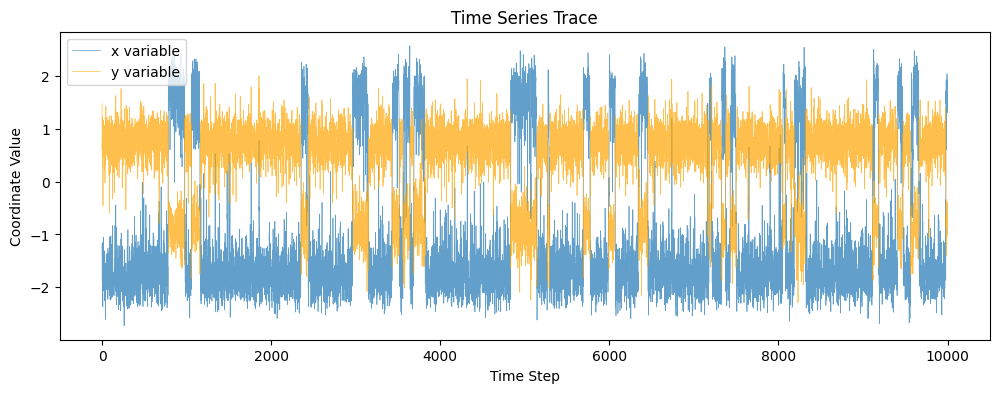

In [70]:
# Plot 1: Time Series
plt.figure(figsize=(12, 4))
plt.plot(df.index, df['x'], label='x variable', alpha=0.7, linewidth=0.5)
plt.plot(df.index, df['y'], label='y variable', alpha=0.7, linewidth=0.5, color='orange')
plt.title('Time Series Trace')
plt.xlabel('Time Step')
plt.ylabel('Coordinate Value')
plt.legend()
plt.show()



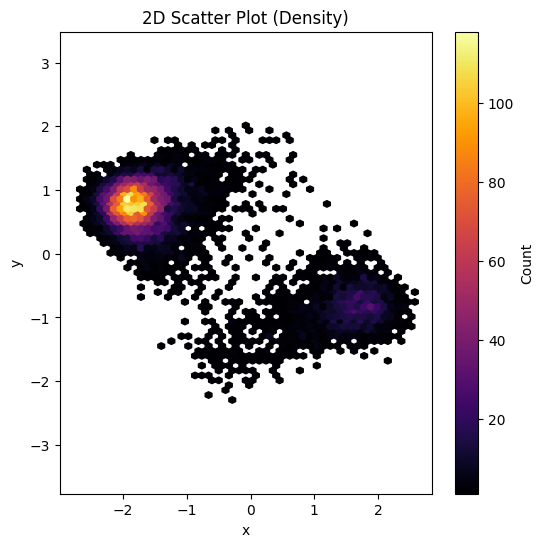

In [80]:
# Plot 2: Phase Space (Scatter)
plt.figure(figsize=(6, 6))
# Using hexbin is often clearer for large density datasets than scatter
plt.hexbin(df['x'], df['y'], gridsize=50, cmap='inferno', mincnt=1)
plt.title('2D Scatter Plot (Density)')
plt.xlabel('x')
plt.ylabel('y')
plt.axis('equal')
plt.colorbar(label='Count')
plt.show()

In [87]:
print(df[['x','y']].std())

x    1.339157
y    0.734765
dtype: float64


In [91]:
from sklearn.model_selection import GridSearchCV

params = {'bandwidth': np.linspace(0.05, 0.1, 0.5)}
grid = GridSearchCV(KernelDensity(kernel='gaussian'), params)
grid.fit(df[['x','y']].values)

print("Optimal bandwidth:", grid.best_params_['bandwidth'])


Optimal bandwidth: 0.10555555555555556


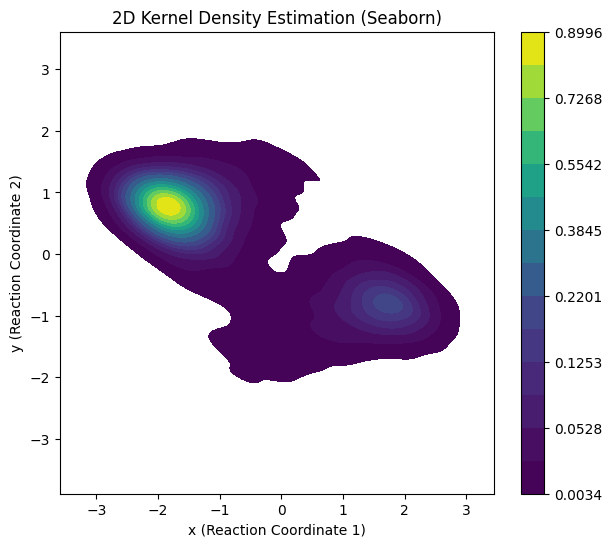

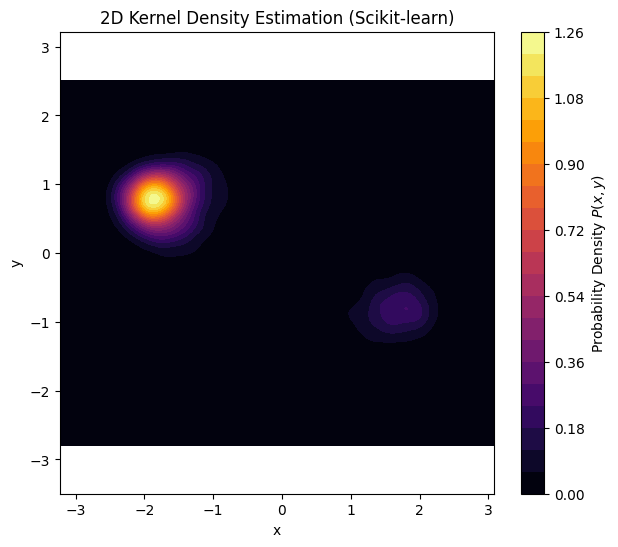

In [92]:
# ---------------------------------------------------------
# Method 1: Seaborn
# ---------------------------------------------------------
# This automatically selects the bandwidth (using Scott's rule) and handles the grid.
# thresh=0 clipping ensures we don't plot extremely low probability regions.

plt.figure(figsize=(7, 6))
sns.kdeplot(
    data=df, x='x', y='y',
    fill=True,           # Fill the contours
    thresh=0.01,         # Lowest iso-contour level to draw
    levels=15,           # Number of contour levels (more = smoother)
    cmap="viridis",      # Standard scientific colormap
    cbar=True            # Add a colorbar
)
plt.title('2D Kernel Density Estimation (Seaborn)')
plt.xlabel('x (Reaction Coordinate 1)')
plt.ylabel('y (Reaction Coordinate 2)')
plt.axis('equal')
plt.show()

# ---------------------------------------------------------
# Method 2: Scikit-learn (Quantitative & Precise)
# ---------------------------------------------------------
# 1. This approach gives us the actual P(x,y) values on a grid

# A value of 0.1  is a reasonable starting point based on the test above.
kde = KernelDensity(bandwidth=0.1, kernel='gaussian')

data_values = df[['x', 'y']].values
kde.fit(data_values)

#  Creating a grid to evaluate the density
x_grid = np.linspace(df['x'].min() - 0.5, df['x'].max() + 0.5, 100)
y_grid = np.linspace(df['y'].min() - 0.5, df['y'].max() + 0.5, 100)
X, Y = np.meshgrid(x_grid, y_grid)
xy_sample = np.vstack([X.ravel(), Y.ravel()]).T

# returns log-density by default
log_density = kde.score_samples(xy_sample)
density = np.exp(log_density).reshape(X.shape)
plt.figure(figsize=(7, 6))

# Using contourf to visualize the scalar field P(x,y)
contour = plt.contourf(X, Y, density, levels=20, cmap='inferno')
plt.colorbar(contour, label='Probability Density $P(x,y)$')
plt.title('2D Kernel Density Estimation (Scikit-learn)')
plt.xlabel('x')
plt.ylabel('y')
plt.axis('equal')
plt.show()

GMM Analysis Results:
------------------------------
Component 1:
  Weight: 0.207
  Mean:   (1.381, -0.865)
------------------------------
Component 2:
  Weight: 0.793
  Mean:   (-1.710, 0.759)
------------------------------


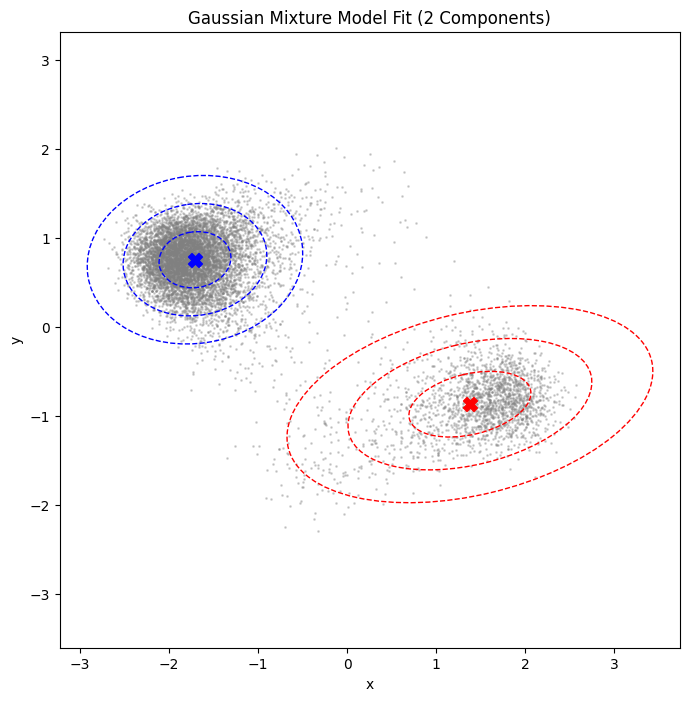

In [93]:
# We use n_components=2 based on visual inspection of the 2D plot
gmm = GaussianMixture(n_components=2, covariance_type='full', random_state=42)
gmm.fit(df[['x', 'y']])

# Extracting parameters
print("GMM Analysis Results:")
print("-" * 30)
for i in range(gmm.n_components):
    weight = gmm.weights_[i]
    mean = gmm.means_[i]
    print(f"Component {i+1}:")
    print(f"  Weight: {weight:.3f}")
    print(f"  Mean:   ({mean[0]:.3f}, {mean[1]:.3f})")
    print("-" * 30)

# Visualize the Gaussians on top of the data
def draw_ellipse(position, covariance, ax=None, **kwargs):
    """Draw an ellipse with a given position and covariance"""
    ax = ax or plt.gca()

    # Convert covariance to principal axes
    if covariance.shape == (2, 2):
        U, s, Vt = np.linalg.svd(covariance)
        angle = np.degrees(np.arctan2(U[1, 0], U[0, 0]))
        width, height = 2 * np.sqrt(s)
    else:
        angle = 0
        width, height = 2 * np.sqrt(covariance)

    # Draw the Ellipse
    for nsig in [1, 2, 3]: # Draw contours at 1, 2, and 3 sigma
        ax.add_patch(Ellipse(position, nsig * width, nsig * height,
                             angle=angle, **kwargs, fill=False))

plt.figure(figsize=(8, 8))
plt.scatter(df['x'], df['y'], s=1, alpha=0.3, color='gray', label='Data')

# Plot the GMM centers and ellipses
colors = ['red', 'blue']
for i in range(gmm.n_components):
    # Plot center
    plt.scatter(gmm.means_[i, 0], gmm.means_[i, 1], c=colors[i], s=100, marker='X', zorder=10)
    # Plot ellipses
    draw_ellipse(gmm.means_[i], gmm.covariances_[i], edgecolor=colors[i], linestyle='--')

plt.title('Gaussian Mixture Model Fit (2 Components)')
plt.xlabel('x')
plt.ylabel('y')
plt.axis('equal')
plt.show()

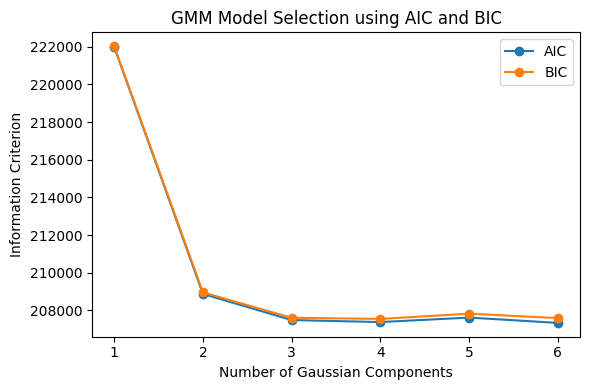

In [108]:
data = np.loadtxt("Dataset_RotatedWQ-Potential.data")

X = data[:, :2]

n_components_range = range(1, 7)

aic_values = []
bic_values = []

for n in n_components_range:
    gmm = GaussianMixture(
        n_components=n,
        #we can define n_initial but I did'nt see any effect of that on the result
        covariance_type="full",
        random_state=42
    )
    gmm.fit(X)

    aic_values.append(gmm.aic(X))
    bic_values.append(gmm.bic(X))

plt.figure(figsize=(6, 4))
plt.plot(n_components_range, aic_values, marker="o", label="AIC")
plt.plot(n_components_range, bic_values, marker="o", label="BIC")

plt.xlabel("Number of Gaussian Components")
plt.ylabel("Information Criterion")
plt.title("GMM Model Selection using AIC and BIC")
plt.legend()
plt.tight_layout()
plt.show()

In [109]:
best_aic_n = n_components_range[np.argmin(aic_values)]
best_bic_n = n_components_range[np.argmin(bic_values)]

print("Optimal number of components based on AIC:", best_aic_n)
print("Optimal number of components based on BIC:", best_bic_n)


Optimal number of components based on AIC: 6
Optimal number of components based on BIC: 4


--------------------------------------------------
Component    | Weight (Model)  | Hard Class % (Data) 
--------------------------------------------------
Cluster 1    | 0.2047          | 20.4880%
Cluster 2    | 0.1410          | 8.6891%
Cluster 3    | 0.5042          | 61.3939%
Cluster 4    | 0.1501          | 9.4291%
--------------------------------------------------


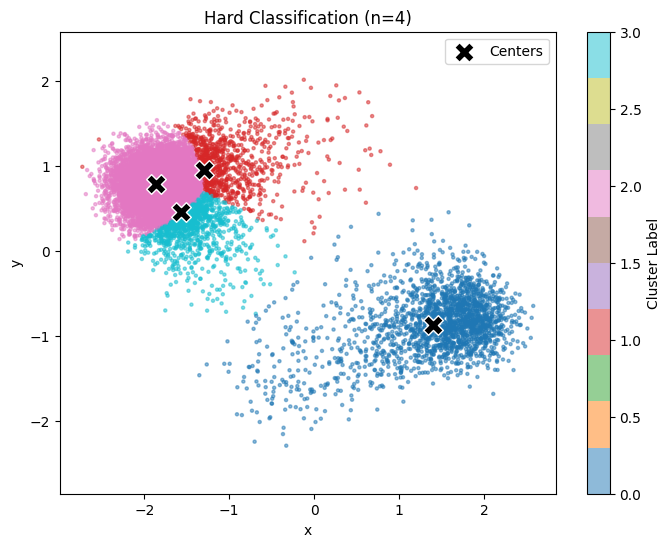

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(


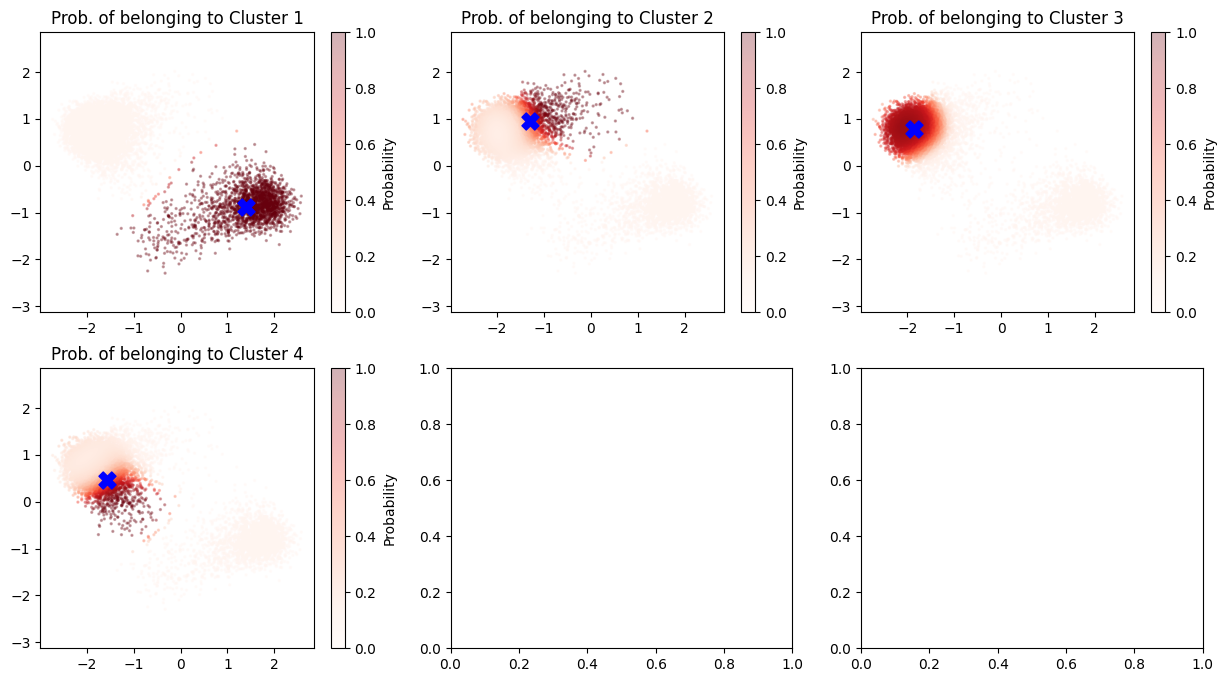

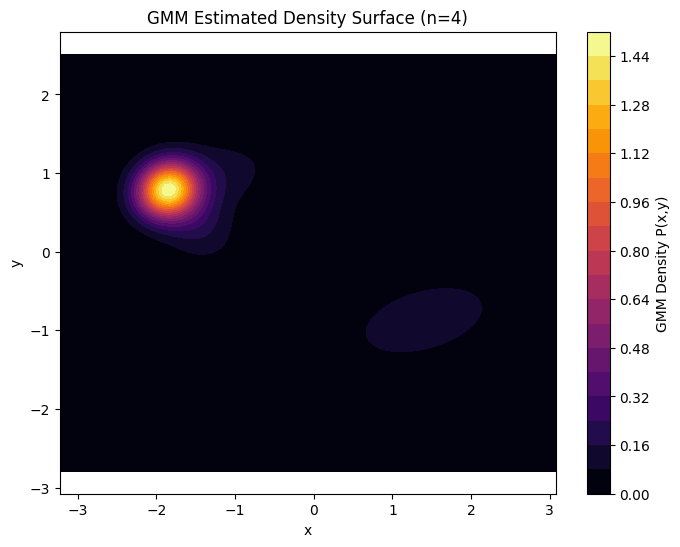

In [113]:

# Based on previous finding, we set n_components = 4
optimal_n = 4
gmm = GaussianMixture(n_components=optimal_n, covariance_type='full', random_state=42)
gmm.fit(df[['x', 'y']])

# ---------------------------------------------------------
# Weights and Hard Classification Stats
# ---------------------------------------------------------
weights = gmm.weights_
hard_labels = gmm.predict(df[['x', 'y']])

# Calculating percentage of samples in each cluster
# We use a Series to count efficiently
counts = pd.Series(hard_labels).value_counts(normalize=True).sort_index()

print("-" * 50)
print(f"{'Component':<12} | {'Weight (Model)':<15} | {'Hard Class % (Data)':<20}")
print("-" * 50)
for i in range(optimal_n):
    # Weight: The mixing coefficient in the mathematical model
    # Hard Class %: The actual fraction of points assigned to this cluster
    print(f"Cluster {i+1:<4} | {weights[i]:.4f}          | {counts.get(i, 0):.4%}")
print("-" * 50)

# ---------------------------------------------------------
# Hard Classification Scatter Plot
# ---------------------------------------------------------
plt.figure(figsize=(8, 6))
# Scatter points colored by their hard label
scatter = plt.scatter(df['x'], df['y'], c=hard_labels, cmap='tab10', s=5, alpha=0.5)
# Plot Centers
plt.scatter(gmm.means_[:, 0], gmm.means_[:, 1], c='black', s=200, marker='X', label='Centers', edgecolors='white')
plt.title(f'Hard Classification (n={optimal_n})')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.colorbar(scatter, label='Cluster Label')
plt.axis('equal')
plt.show()

# ---------------------------------------------------------
# Soft Classification Plots (Probabilities)
# ---------------------------------------------------------
# We get the probability matrix: (n_samples, n_components)
soft_probs = gmm.predict_proba(df[['x', 'y']])

# Create a grid of subplots to show probability for EACH cluster
rows = (optimal_n + 2) // 3  # Calculate required rows for 3 columns
fig, axes = plt.subplots(rows, 3, figsize=(15, 4 * rows))
axes = axes.flatten()

for i in range(optimal_n):
    ax = axes[i]
    # Color points by probability of belonging to Cluster i
    # We use a sequential colormap (Reds) so white = 0%, Dark Red = 100%
    sc = ax.scatter(df['x'], df['y'], c=soft_probs[:, i], cmap='Reds', s=2, alpha=0.3, vmin=0, vmax=1)

    # Mark the center of ONLY this component
    ax.scatter(gmm.means_[i, 0], gmm.means_[i, 1], c='blue', s=150, marker='X')

    ax.set_title(f'Prob. of belonging to Cluster {i+1}')
    ax.axis('equal')
    fig.colorbar(sc, ax=ax, label='Probability')

# Hide empty subplots (there was 2 of them)
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

# ---------------------------------------------------------
# GMM Density Surface (P(x,y))
# ---------------------------------------------------------
x_grid = np.linspace(df['x'].min() - 0.5, df['x'].max() + 0.5, 100)
y_grid = np.linspace(df['y'].min() - 0.5, df['y'].max() + 0.5, 100)
XX, YY = np.meshgrid(x_grid, y_grid)
XY = np.vstack([XX.ravel(), YY.ravel()]).T


# score_samples returns log-probability, so we take exp()
Z = np.exp(gmm.score_samples(XY))
Z = Z.reshape(XX.shape)

plt.figure(figsize=(8, 6))
contour = plt.contourf(XX, YY, Z, levels=20, cmap='inferno')
plt.colorbar(contour, label='GMM Density P(x,y)')
plt.title(f'GMM Estimated Density Surface (n={optimal_n})')
plt.xlabel('x')
plt.ylabel('y')
plt.axis('equal')
plt.show()

A Gaussian Mixture Model with n = 4 components was fitted to the data. The component weights reflect how the samples are distributed among the main metastable regions. Hard classification assigns each point to the most likely cluster, and the resulting cluster populations are consistent with these weights.
Soft classification shows smooth transitions between clusters, indicating overlap between the Gaussian components. The GMM estimate of P(x,y) captures the main basins seen in the KDE plot, but is smoother and more structured. While KDE resolves finer details, the GMM provides a simpler and more interpretable description of the dominant states.